In [ ]:
# Download the dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GeIz3GMuWIRTi_BtW6cYy39O0Mu3ujRF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GeIz3GMuWIRTi_BtW6cYy39O0Mu3ujRF" -O english_hindi.csv && rm -rf /tmp/cookies.txt

In [2]:
# import necessary packages and libraries
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow import keras

from sklearn.model_selection import train_test_split

## Load and Preprocess data

In [3]:
# write a preprocess function
def preprocess(df, source_col, dest_col):
    # get list of punctuation
    punctuations = string.punctuation
    digits = string.digits
    
    remove_digits = str.maketrans('', '', digits)
    # copy the dataset
    dataset = df.copy()
    # convert to lower case
    dataset[source_col] = dataset[source_col].apply(lambda x: x.lower())
    dataset[dest_col] = dataset[dest_col].apply(lambda x: x.lower())
    
    # remove all the punctuations
    dataset[source_col] = dataset[source_col].apply(lambda x: "".join([c for c in x if c not in punctuations]))
    dataset[dest_col] = dataset[dest_col].apply(lambda x: "".join([c for c in x if c not in punctuations]))
    
    # remove all the numbers
    dataset[source_col] = dataset[source_col].apply(lambda x: x.translate(remove_digits))
    dataset[dest_col] = dataset[dest_col].apply(lambda x: x.translate(remove_digits))
    dataset[dest_col] = dataset[dest_col].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))
    
    # Remove extra spaces
    dataset[source_col]=dataset[source_col].apply(lambda x: x.strip())
    dataset[dest_col]=dataset[dest_col].apply(lambda x: x.strip())
    dataset[source_col]=dataset[source_col].apply(lambda x: re.sub(" +", " ", x))
    dataset[dest_col]=dataset[dest_col].apply(lambda x: re.sub(" +", " ", x))
    
    return dataset

In [4]:
# load the dataset
dataset = pd.read_csv("english_hindi.csv")

# remove unnecessary column
dataset = dataset.drop("source", axis=1)

# drop null values
dataset = dataset.dropna(axis=0)

# preprocess the dataset
new_data = preprocess(dataset, "english_sentence", "hindi_sentence")

# add the start and end tokens to the target sentence
new_data['hindi_sentence'] = new_data['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')

# calculate total words in each sentence
new_data["english_nw"] = new_data['english_sentence'].apply(lambda x: len(x.split())) 
new_data["hindi_nw"] = new_data['hindi_sentence'].apply(lambda x: len(x.split())) 

# let's take sentences only upto 20 words max.
max_sent_len = 20
new_data = new_data[new_data.english_nw <= max_sent_len]
new_data = new_data[new_data.hindi_nw <= max_sent_len]

# create tokenizers
eng_tokenizer = Tokenizer(filters='', oov_token='UNK')
hin_tokenizer = Tokenizer(filters='', oov_token='UNK')
# fit tokenizers on respective data
eng_tokenizer.fit_on_texts(new_data["english_sentence"])
hin_tokenizer.fit_on_texts(new_data['hindi_sentence'])

# get source vocab size
eng_vocabsize = len(eng_tokenizer.word_index)
# get target vocab size
hin_vocabsize = len(hin_tokenizer.word_index)

# separate the data into training, testing and validation
source_sent = new_data['english_sentence']
target_sent = new_data["hindi_sentence"]

# split
X_train, X_test, Y_train, Y_test = train_test_split(source_sent, target_sent, test_size=0.2, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape

print("Number of Unique words in english sentences: {}".format(eng_vocabsize))
print("Number of unique words in hindi sentences: {}".format(hin_vocabsize))


Number of Unique words in english sentences: 41593
Number of unique words in hindi sentences: 43172


 ## Create Datasets

In [6]:
# write a function to create dataset
def create_dataset(source, target, src_tokenizer=eng_tokenizer, tar_tokenizer=hin_tokenizer):
    source_in = src_tokenizer.texts_to_sequences(source)
    target = tar_tokenizer.texts_to_sequences(target)
    
    # convert to ragged tensor
    source_in = tf.ragged.constant(source_in)
    target = tf.ragged.constant(target)
    # create target input and target output
    target_in = target[:, :-1] # without end token
    target_out = target[:, 1:] # without start token
    
    # pad all data to max len
    source_in_padded = source_in.to_tensor(default_value=0)
    target_in_padded = target_in.to_tensor(default_value=0)
    target_out_padded = target_out.to_tensor(default_value=0)
    
    # create a tensorflow datasest
    dataset = tf.data.Dataset.from_tensor_slices(((source_in_padded, target_in_padded), target_out_padded))
    # batch and prefetch dataset
    dataset = dataset.batch(32).prefetch(1)
    return dataset

In [7]:
# create train, valid and test dataset
train_dataset = create_dataset(X_train, Y_train)
valid_dataset = create_dataset(X_valid, Y_valid)
test_dataset = create_dataset(X_test, Y_test)

## Build the Model

In [8]:
# define embedding size
src_embed = 128
target_embed = 128
units = 300

# define inputs
encoder_inputs = Input(shape=[None], dtype=tf.int32)
decoder_inputs = Input(shape=[None], dtype=tf.int32)

# encoder embeddings
encoder_embeddings = Embedding(eng_vocabsize+1, src_embed, mask_zero=True)(encoder_inputs)
# define encoder lstm layers
encoder_lstm_layer1 = LSTM(units, return_sequences=True, dropout=0.3)
encoder_lstm_layer2 = LSTM(units, return_state=True, dropout=0.3)
# get encoder states
layer1_out = encoder_lstm_layer1(encoder_embeddings)
_, en_state_h, en_state_c = encoder_lstm_layer2(layer1_out)
encoder_states = [en_state_h, en_state_c]

# Decoder embeddings
decoder_embeddings = Embedding(hin_vocabsize+1, target_embed, mask_zero=True)(decoder_inputs)
decoder_lstm_layer = LSTM(units, return_sequences=True)
decoder_lstm_output = decoder_lstm_layer(decoder_embeddings, initial_state=encoder_states)
# get decoder final output
decoder_output = Dense(hin_vocabsize+1, activation="softmax")(decoder_lstm_output)

# Create a model
model_drop = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[decoder_output])
# display model summary
model_drop.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    5324032     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 300)    514800      embedding[0][0]                  
______________________________________________________________________________________________

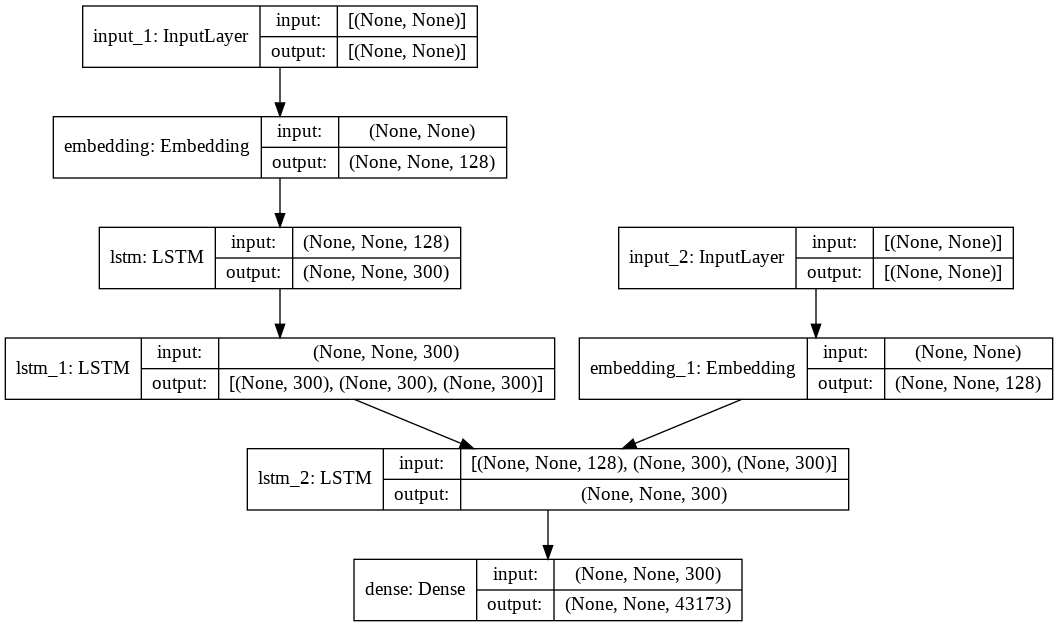

In [9]:
from tensorflow.keras.utils import plot_model

plot_model(model_drop, to_file='train_model-1.png', show_shapes=True)

## Train the Model

In [ ]:
# checkpoint model
save_path = "drive/MyDrive/english_hindi_project/models/model_drop_weigts.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(save_path, save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# define optimizer
optimizer = tf.keras.optimizers.Adam()
# compile model
model_drop.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

# fit the model
history = model_drop.fit(train_dataset, epochs=30, batch_size=32, validation_data=valid_dataset, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
2133/2133 [==============================] - 311s 142ms/step - loss: 3.4618 - accuracy: 0.1542 - val_loss: 3.1559 - val_accuracy: 0.1864
Epoch 2/30
2133/2133 [==============================] - 297s 139ms/step - loss: 2.8843 - accuracy: 0.2129 - val_loss: 2.8889 - val_accuracy: 0.2282
Epoch 3/30
2133/2133 [==============================] - 299s 140ms/step - loss: 2.4955 - accuracy: 0.2621 - val_loss: 2.7290 - val_accuracy: 0.2581
Epoch 4/30
2133/2133 [==============================] - 295s 138ms/step - loss: 2.1710 - accuracy: 0.3131 - val_loss: 2.6401 - val_accuracy: 0.2861
Epoch 5/30
2133/2133 [==============================] - 296s 139ms/step - loss: 1.9073 - accuracy: 0.3631 - val_loss: 2.6008 - val_accuracy: 0.3062
Epoch 6/30
2133/2133 [==============================] - 294s 138ms/step - loss: 1.6949 - accuracy: 0.4140 - val_loss: 2.5851 - val_accuracy: 0.3226
Epoch 7/30
2133/2133 [==============================] - 293s 137ms/step - loss: 1.5233 - accuracy: 0.4602 - val_

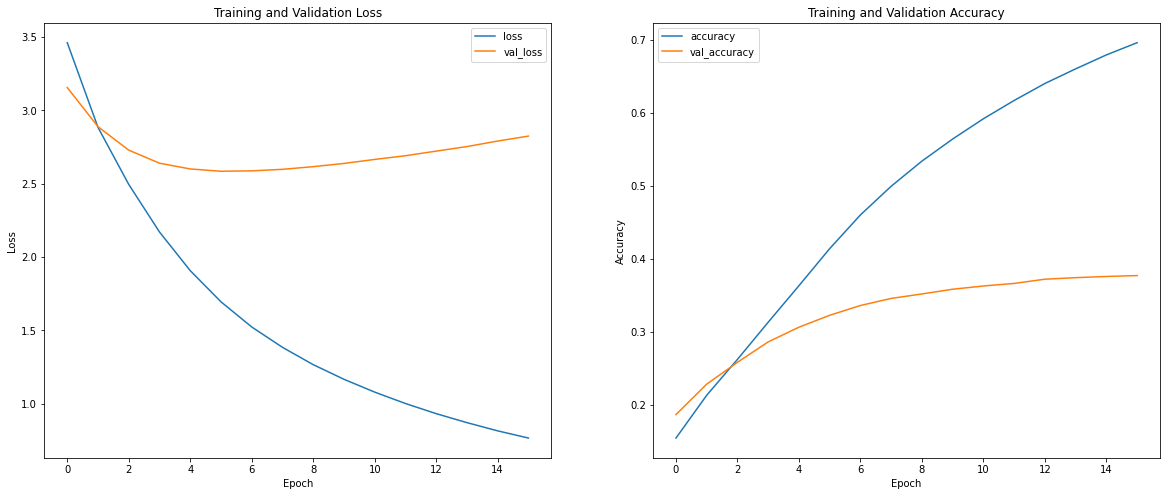

In [ ]:
# plot loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
pd.DataFrame(history.history)[["loss", "val_loss"]].plot(ax=ax[0])
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot(ax=ax[1])
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].set_title("Training and Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
plt.savefig("/content/drive/MyDrive/english_hindi_project/images/fig1.png")
plt.show()


## Evaluate on a test set

In [ ]:
loss, acc = model_drop.evaluate(test_dataset, verbose=0)
print("{:25s}".format("Performance on Test Set"))
print("Loss: {}\nAccuracy: {:.2f}%".format(loss, acc*100))

Performance on Test Set  
Loss: 2.629542112350464
Accuracy: 31.98%


In [14]:
# load the saved model
save_path = "drive/MyDrive/english_hindi_project/models/model_drop_weigts.h5"
model_drop.load_weights(save_path)

In [10]:
def prepare_data(sent):
    sent_tokens = eng_tokenizer.texts_to_sequences([sent])
    ragged_tokens = tf.ragged.constant(sent_tokens)
    return ragged_tokens.to_tensor(shape=(None, max_sent_len))

In [11]:
# write a function which returns the translated text in hindi
def translate(eng_sent, model):
    
    # prepare y_pred
    Y_pred = tf.fill(dims=(1, 1), value=2)
    # prepare encoder input
    X_encoder = prepare_data(eng_sent)
    
    index = 0
    next_ = 0
    # loop until max target length or until end token is predicted
    while index < max_sent_len and next_ != 3:
        # calculate the padding size
        padsize = max_sent_len - Y_pred.shape[1]
        # create input for decoder
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, padsize]])
        # get the probabilities of next prediction
        Y_proba = model.predict([X_encoder, X_decoder])[:, index:index+1]
        # get the next predicted token
        Y_proba_next = tf.argmax(Y_proba, axis=-1, output_type=tf.int32)
        # concatenate with Y_pred to predict next word
        Y_pred = tf.concat([Y_pred, Y_proba_next], axis=1)
        # assign current predicted token to next
        next_ = Y_proba_next.numpy()[0][0]
        # increment the index value
        index += 1
    # translate the sentences and return all except start and end tokens
    translated_sent = hin_tokenizer.sequences_to_texts(Y_pred.numpy())
    return " ".join(translated_sent[0].split()[1:-1])

In [15]:
# for reproducible result
np.random.seed(42)
# get 10 random indices
random_indices = np.random.randint(X_test.shape[0], size=10)

# predict on test sentences
for index in random_indices:
    eng_sent = list(X_test)[index]
    org_hindi = list(Y_test)[index]
    translated = translate(eng_sent, model_drop)
    print("\nEnglish: {}\nHindi Org: {}\nHindi Translated: {}".format(eng_sent,
                                                                    org_hindi,
                                                                    translated))
    print("*"*100)


English: but i cannot recall a day without it
Hindi Org: START_ पर एसा एक दिन नही जो मेंने उसके बिना बिताया हो _END
Hindi Translated: लेकिन मुझे लगता है कि किसी का कोई कोई नहीं है
****************************************************************************************************

English: then drona became the commanderinchief of the army
Hindi Org: START_ तब आचार्य द्रोण ने सेनापतित्व का भार ग्रहण किया। _END
Hindi Translated: फिर अश्वत्थामा ने उत्तरा का राजतिलक हुआ।
****************************************************************************************************

English: we found however that fault lay with the experiment and not the bee
Hindi Org: START_ लेकिन मैंने यह पाया कि कमी मक़्खी में नहीं बल्कि प्रयोग में थी _END
Hindi Translated: हम जीतने वाले हैं और हम उन्हें एक साथ नहीं बनाते
****************************************************************************************************

English: references
Hindi Org: START_ संदर्भ _END
Hindi Translated: संदर्भ
*****************